In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import insightface
from skimage import transform

In [2]:
# Set global parameters for all plots
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

In [3]:
# This work was inspired by following post:
# https://learnopencv.com/using-facial-landmarks-for-overlaying-faces-with-masks/

In [4]:
facial_image_path = '../img/sunglasses/tiger_woods2.jpg'
sunglasses_path = '../img/sunglasses/sunglasses.png'

In [5]:
def load_images():
    facial_image = cv2.imread(facial_image_path)
    facial_image = cv2.cvtColor(facial_image, cv2.COLOR_BGR2RGB)

    sunglasses = cv2.imread(sunglasses_path, cv2.IMREAD_UNCHANGED)
    sunglasses = cv2.cvtColor(sunglasses, cv2.COLOR_BGRA2RGBA)

    return facial_image, sunglasses
    

# Putting Glasses On Facial image

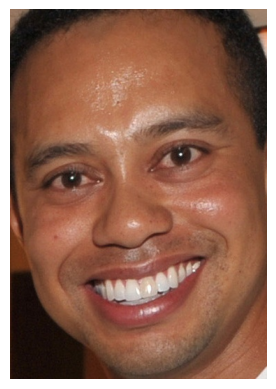

In [6]:
facial_image, _ = load_images()
plt.imshow(facial_image)
plt.show()

## Facial key points detection

In [7]:
# initialization of insightface takes time if not run on GPU machine
model = insightface.app.FaceAnalysis(allowed_modules=['detection', "landmark_3d_68"])
model.prepare(ctx_id=-1, det_thresh=0.1, det_size=(320, 320))

/Users/yudkin/miniconda3/envs/kinsame/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/yudkin/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/yudkin/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/yudkin/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/yudkin/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/yudkin/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (320, 320)


In [8]:
result = model.get(facial_image)

/Users/yudkin/miniconda3/envs/kinsame/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [9]:
bbox = result[0]['bbox']
landmarks = result[0]['landmark_3d_68']

### Lets plot the keypoints on the face

In [10]:
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1
point_color = (0, 0, 255)

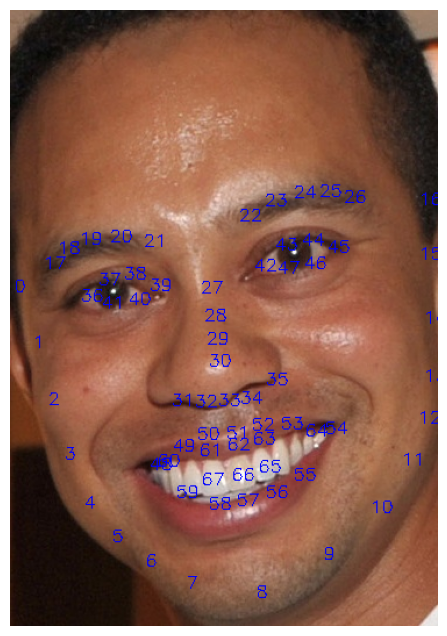

In [11]:
plt.figure(figsize=(8, 8))
for j, (x, y, z) in enumerate(landmarks):
    cv2.putText(facial_image, str(j), (int(x), int(y)), font, font_scale, point_color, font_thickness)
plt.imshow(facial_image)

plt.show()

### Plotting only the eyes 


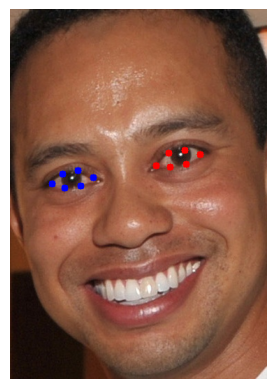

In [12]:
facial_image, _ = load_images()

left_eye_idx = [36,37,38, 39, 40, 41]
right_eye_idx = [42, 43, 44, 45, 46, 47]

for j, (x, y, z) in enumerate(landmarks):
    if j in left_eye_idx:
        cv2.circle(facial_image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)
    elif j in right_eye_idx:
        cv2.circle(facial_image, (int(x), int(y)), radius=5, color=(255, 0, 0), thickness=-1)
        
plt.imshow(facial_image)
plt.show()

## Now Lets see the glasses

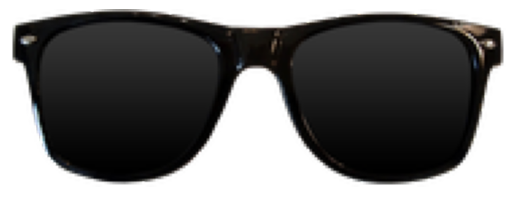

In [15]:
facial_image, sunglasses = load_images()

plt.imshow(sunglasses)
plt.show()

### Glasses - we need to find the center of each side of the sunglasses

In [16]:
shape = sunglasses.shape
print(shape)
center_height= shape[0] // 2
left_x = shape[1] // 4
right_x = shape[1] - shape[1] // 4

left_glasses_center = (left_x, center_height)
right_glasses_center = (right_x, center_height)

(66, 184, 4)


### Let's do the transformation between the face and the glasses

In [17]:
facial_image, sunglasses = load_images()

In [18]:
#sunglasses[sunglasses[:,:,3] < 64] = 0
sunglasses[sunglasses[:,:,3] > 64, 3] = 255
sunglasses[:,:,3] = sunglasses[:,:,3] / 255

In [19]:
# mean of the left eye
left_eye = [landmarks[i] for i in left_eye_idx]
x_coordinates, y_coordinates, _ = zip(*left_eye)
left_eye_center = (np.mean(x_coordinates), np.mean(y_coordinates))

In [20]:
# mean of the right eye
right_eye = [landmarks[i] for i in right_eye_idx]
x_coordinates, y_coordinates, _ = zip(*right_eye)
right_eye_center = (np.mean(x_coordinates), np.mean(y_coordinates))

In [21]:
g_height, g_width, _ = sunglasses.shape

#source coordinates
src_pts = np.array([(0, 0), 
                    (g_width, 0), 
                    (0, g_height), 
                    (g_width, g_height),
                    (g_width//2, 0)])

x_idx = 0
y_idx = 1

#destination coordinates
dst_pts = np.array([(landmarks[0][x_idx], 0.9*landmarks[0][y_idx]), 
                    (landmarks[16][x_idx], 0.9*landmarks[16][y_idx]), 
                    (landmarks[1][x_idx], 1.1*landmarks[1][y_idx]), 
                    (landmarks[15][x_idx], 1.1*landmarks[15][y_idx]),
                    # point upper nose point
                    ((landmarks[22][x_idx] - landmarks[21][x_idx]) //2 + landmarks[21][x_idx] ,   np.mean([landmarks[22][y_idx], landmarks[21][y_idx]])),
                   ])

In [22]:
# get the perspective transformation matrix
M, _ = cv2.findHomography(src_pts, dst_pts)

In [23]:
#not needed as we already have alpha channel
# alpha = 1 * np.ones((sunglasses.shape[0], sunglasses.shape[1], 1))
# sunglasses = np.concatenate([sunglasses, alpha], axis=2)

In [24]:
sunglasses.shape

(66, 184, 4)

In [25]:
# transformed masked image
transformed_sunglasses = cv2.warpPerspective(
            sunglasses,
            M,
            (facial_image.shape[1], facial_image.shape[0]),
            None,
            cv2.INTER_LINEAR,
            cv2.BORDER_CONSTANT,
        )

In [26]:
# mask overlay
alpha_mask = transformed_sunglasses[:, :, 3]
alpha_image = 1.0 - alpha_mask

for c in range(0, 3):
    facial_image[:, :, c] = (alpha_mask * transformed_sunglasses[:, :, c] + alpha_image * facial_image[:, :, c])

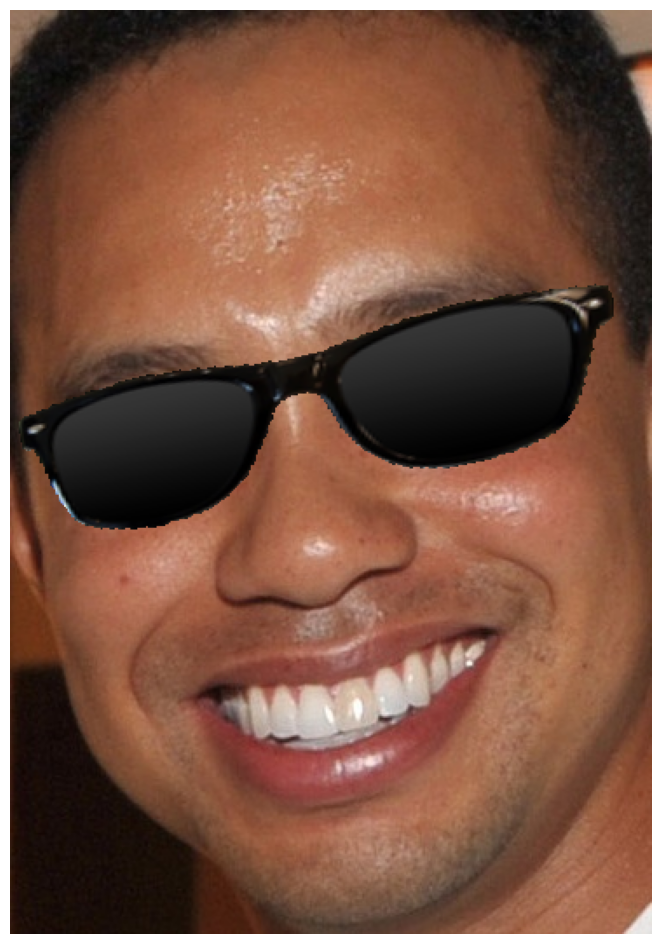

In [27]:
plt.figure(figsize=(12, 12))
plt.imshow(facial_image)
plt.show()